In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits
import dask.array as da

from cycspec_simulator import (
    TemplateProfile,
    BasebandModel,
    FreqOnlyPredictor,
    PolynomialPredictor,
    ExponentialScatteringModel,
    Time,
    ObservingMetadata,
    pspec_numba,
    guppi_raw,
)
from cycspec_simulator.scattering import ScintillationPattern

%matplotlib notebook

In [2]:
obsfreq = 1.5e9 # Hz
chan_bw = 1.5625e6 # Hz
nchan = 2

In [3]:
scattering_model = ExponentialScatteringModel(
    scattering_time=40e-6, chan_bw=1.5625e6, nchan=2, obsfreq=1.5e9,
)
pattern = scattering_model.realize()

<IPython.core.display.Javascript object>


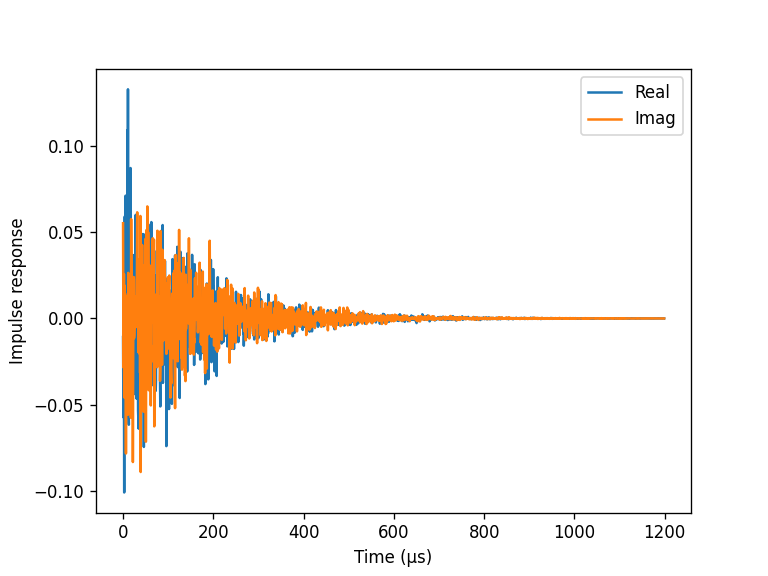

In [4]:
pattern.plot_impulse_response()
plt.show()

<IPython.core.display.Javascript object>


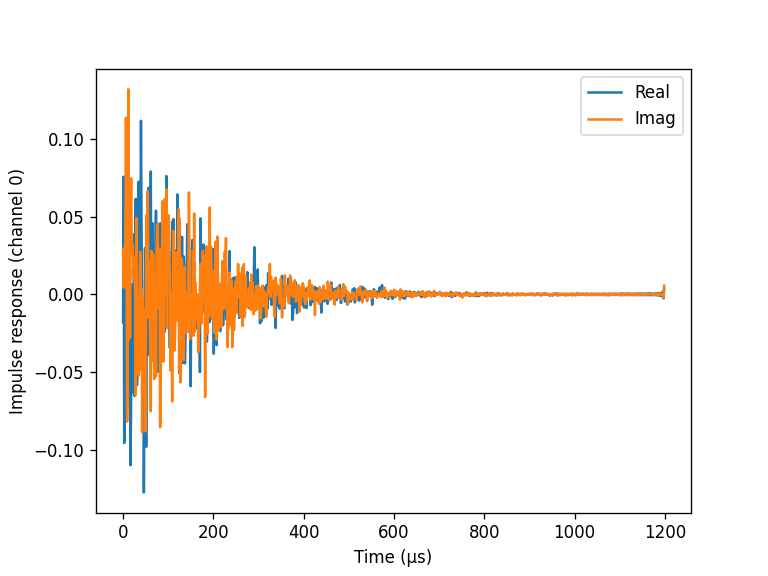

In [5]:
pattern.plot_impulse_response(0)
plt.show()

<IPython.core.display.Javascript object>


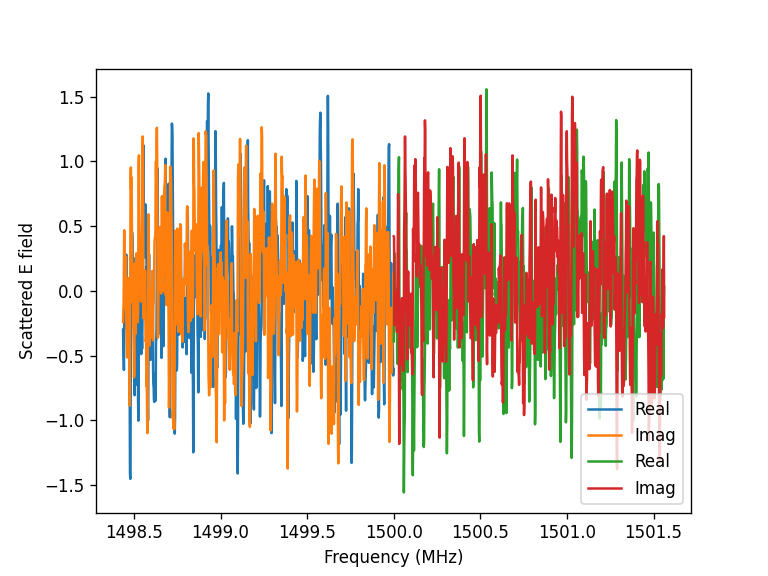

In [6]:
fig, ax = plt.subplots()
pattern.plot_filter_function(0, ax)
pattern.plot_filter_function(1, ax)
plt.show()

<IPython.core.display.Javascript object>


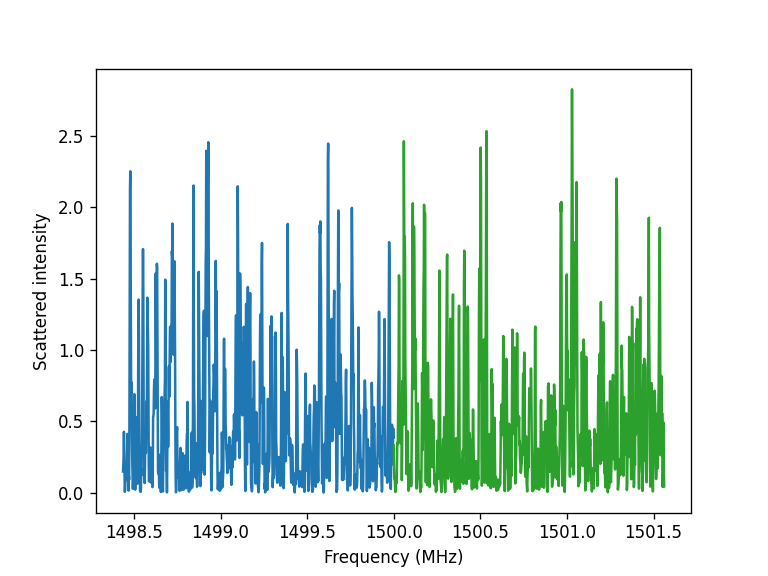

In [7]:
fig, ax = plt.subplots()
pattern.plot_scattered_intensity(0, ax, color='C0')
pattern.plot_scattered_intensity(1, ax, color='C2')
plt.show()

In [8]:
template_file = "B1937+21.Rcvr1_2.GUPPI.15y.x.sum.sm"
template = TemplateProfile.from_file(template_file)
template.normalize()
template.make_posdef()

Adjusting I**2 by 5.5361972783884994e-08


In [9]:
predictor = PolynomialPredictor.from_file("polyco-B1937+21-60000.dat")
model = BasebandModel(template, chan_bw=chan_bw, predictor=predictor, nchan=nchan, obsfreq=obsfreq)

In [10]:
t_start = Time(60000, 1800, -(pattern.impulse_response.shape[-1]-1)/chan_bw)
data = model.sample(2**22 + pattern.impulse_response.shape[-1] - 1, t_start=t_start)
data = pattern.scatter(data)

In [11]:
%time pspec = pspec_numba(data, 1024, 1024, predictor)

CPU times: user 3min 42s, sys: 791 ms, total: 3min 43s
Wall time: 3min 42s


<IPython.core.display.Javascript object>


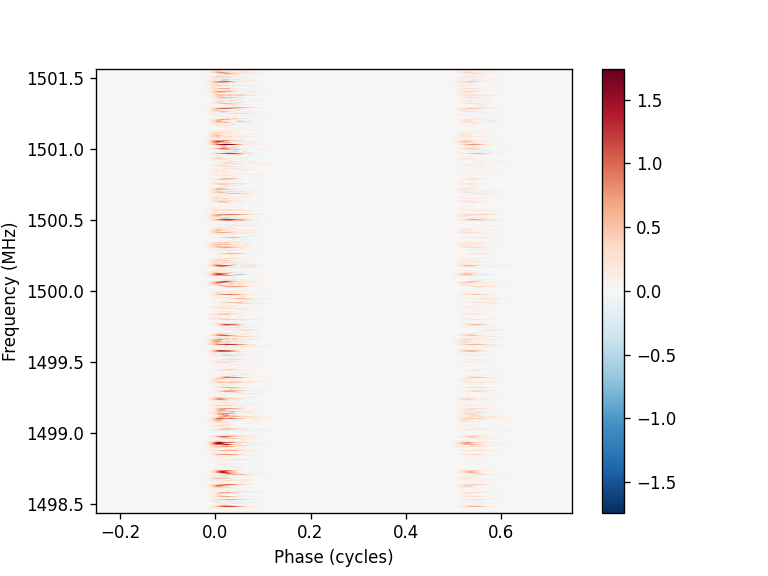

In [12]:
pc = pspec.plot(shift=0.25, cmap='RdBu_r', sym_lim=True)
plt.colorbar(pc)
plt.show()

In [13]:
metadata = ObservingMetadata.from_file(template_file)
metadata.observer = "cycspec-simulator"
guppi_raw.write('B1937+21-true2chan.raw', data, metadata=metadata)

In [14]:
spb = (2**22 - 12288)//4
guppi_raw.write('B1937+21-true2chan-overlap.raw', data, metadata=metadata, samples_per_block=spb, overlap=12288)